#  Exploratory Regression models

In [4]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Parameters
segment_results = 'Y'  # Set to 'Y' to segment results by a specific column or 'N' to run the model on the entire dataset
segmentation_column = 'Generation'  # The column used for segmentation
filter_column = None  # The column used for filtering
filter_values = None  # List of values to exclude from the dataset
pvalue_threshold = 0.05  # P-value threshold for significance
y_column = 'Yvar_USE_AI_Work'  # Dependent variable
x_column_prefix = 'VAR'  # Prefix for independent variables
output_filename_template = 'Regression_Results_{segmentation_column}_Detailed.xlsx'  # Template for output filename

# Define the path to your dataset
current_directory = os.getcwd()
excel_path = os.path.join(current_directory, '01-data', 'TAM_DEF.xlsx')
summary_dir = os.path.join(current_directory, '04-summary')

# Ensure the summary directory exists
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

# Load the dataset
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {excel_path}")
    exit()
except Exception as e:
    print(f"Error during dataset loading: {e}")
    exit()

# Apply filtering if filter_column and filter_values are set
if filter_column and filter_values:
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered dataset to exclude {filter_values} in {filter_column}")

if segment_results == 'Y':
    # Get unique values in the segmentation column
    segments = df[segmentation_column].unique()
    print(f"Found {segmentation_column} segments: {segments}")
else:
    # If not segmenting, treat the entire dataset as a single segment
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Add a dummy column to facilitate the loop

# Loop through each segment and run the regression model
all_results = []
top_variables_set = set()

for segment in segments:
    df_segment = df[df[segmentation_column] == segment] if segment != 'Entire Dataset' else df
    
    # Define X (independent variables) and y (dependent variable)
    X = df_segment.filter(regex=f'^{x_column_prefix}')
    y = df_segment[y_column]
    
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the results, filtering by p-value threshold
    significant_results = model.summary2().tables[1]
    significant_results = significant_results[significant_results['P>|t|'] <= pvalue_threshold]
    
    # Exclude the constant from the top variables set
    top_variables_set.update(var for var in significant_results.index.tolist() if var != 'const')
    
    # Append results to the list for later export
    segment_results = significant_results.reset_index()
    segment_results.insert(0, 'Segment', segment)
    segment_results.insert(1, 'R2 Value', model.rsquared)
    all_results.append(segment_results)

# Combine the results from all segments into a DataFrame
all_results_df = pd.concat(all_results)

# Run overall regression with combined top variables
combined_X = df[list(top_variables_set)]
combined_X = sm.add_constant(combined_X)
combined_model = sm.OLS(df[y_column], combined_X).fit()

# Prepare overall model results for export
overall_results = combined_model.summary2().tables[1].reset_index()
overall_results.insert(0, 'Segment', 'Overall')
overall_results.insert(1, 'R2 Value', combined_model.rsquared)

# Save the results to Excel, including the segmentation column name in the filename
output_filename = output_filename_template.format(segmentation_column=segmentation_column)
output_path = os.path.join(summary_dir, output_filename)

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    # Write the overall hypothesis results
    all_results_df.to_excel(writer, sheet_name='Hypothesis Results', index=False)
    
    # Write the overall regression results
    overall_results.to_excel(writer, sheet_name='Overall Regression', index=False)

    # Apply formatting
    workbook = writer.book
    header_format = workbook.add_format({
        'bold': True, 'text_wrap': True, 'align': 'center', 'valign': 'center', 'bg_color': '#D9EAD3'
    })
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_row(0, None, header_format)
        worksheet.set_column('A:G', 20)  # Adjust column width for better readability

    print(f"Summary statistics and regression results saved to {output_path}.")

Dataset loaded successfully.
Found Generation segments: ['Boomer' 'Gen Z' 'Gen X' 'Millennial']
Summary statistics and regression results saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/Regression_Results_Generation_Detailed.xlsx.


# Diagram

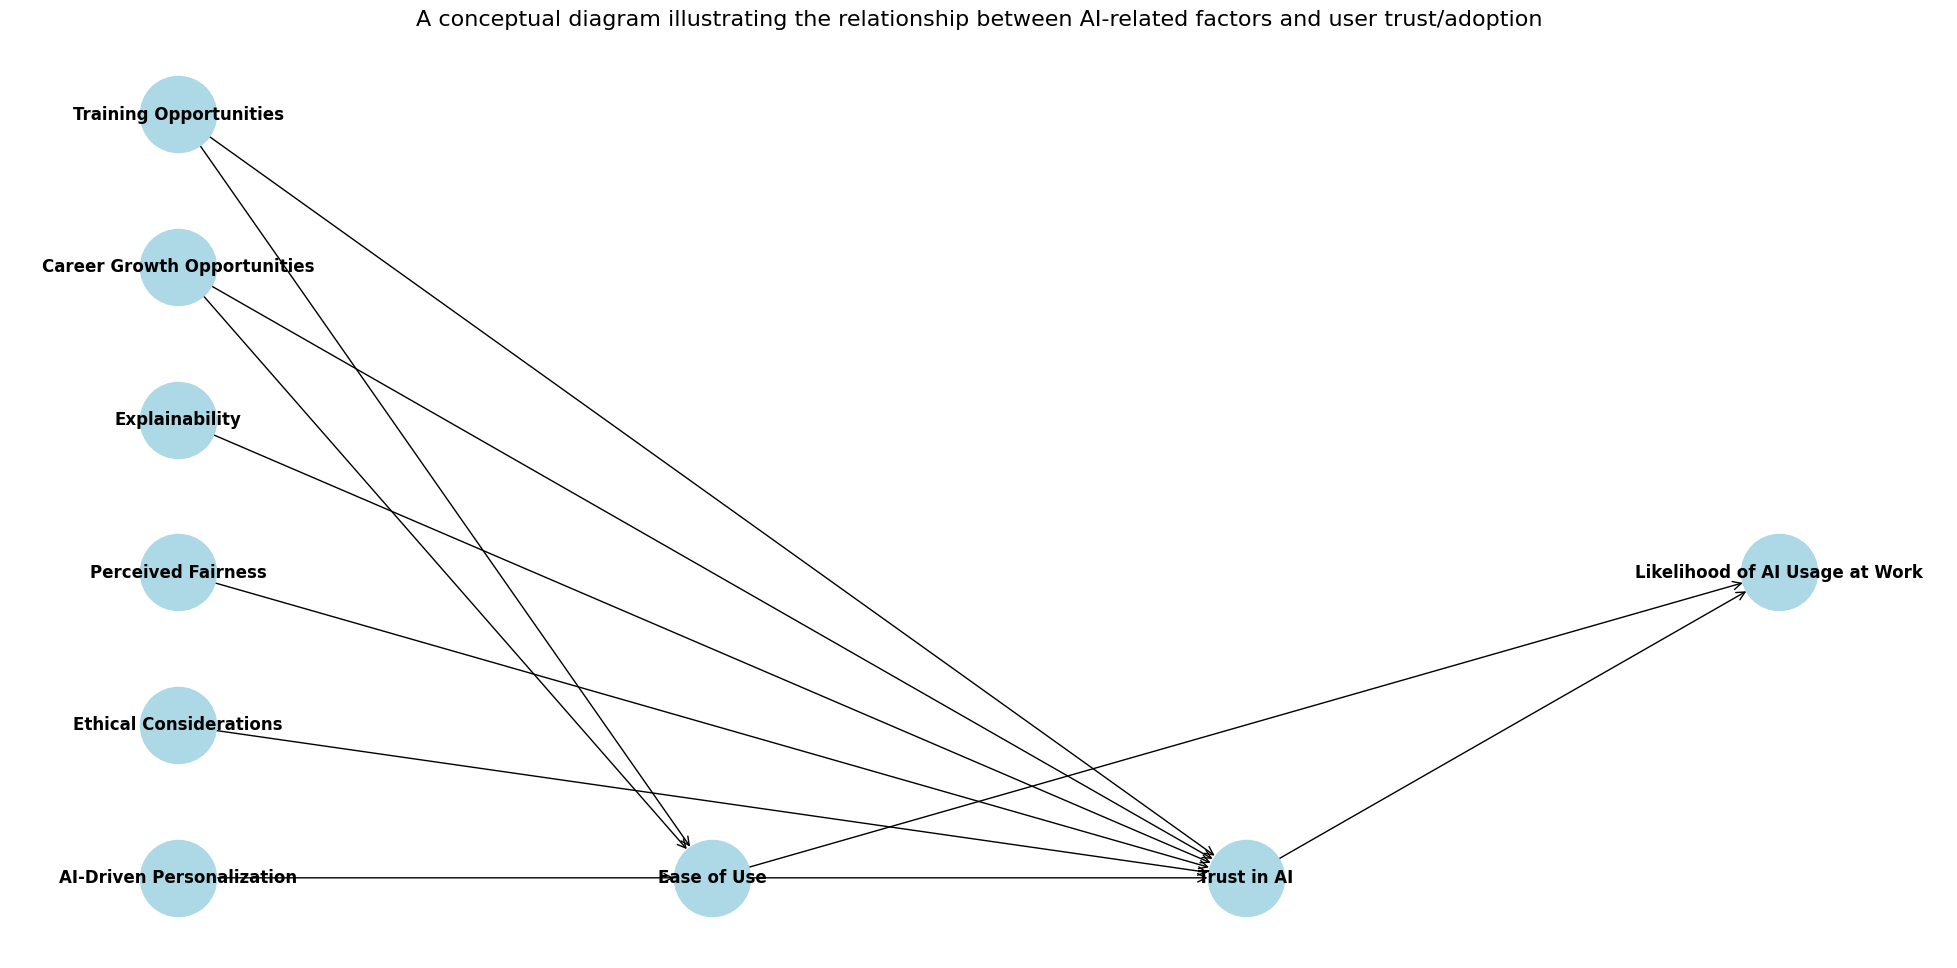

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define the nodes and their positions for a left-to-right layout
nodes = {
    "Training Opportunities": (0, 10),
    "Career Growth Opportunities": (0, 9),
    "Explainability": (0, 8),
    "Perceived Fairness": (0, 7),
    "Ethical Considerations": (0, 6),
    "AI-Driven Personalization": (0, 5),
    "Ease of Use": (5, 5),
    "Trust in AI": (10, 5),
    "Likelihood of AI Usage at Work": (15, 7)
}

# Define the edges based on the new relationships
edges = [
    # Hypothesis 1: Training and Career Growth Opportunities Influence Ease of Use and Trust
    ("Training Opportunities", "Ease of Use"),
    ("Career Growth Opportunities", "Ease of Use"),
    ("Training Opportunities", "Trust in AI"),
    ("Career Growth Opportunities", "Trust in AI"),
    
    # Hypothesis 2: Explainability and Fairness Influence User Trust and AI Adoption
    ("Explainability", "Trust in AI"),
    ("Perceived Fairness", "Trust in AI"),
    
    # Hypothesis 3: Ethical Development and Social Responsibility Influence User Trust
    ("Ethical Considerations", "Trust in AI"),
    
    # Hypothesis 4: AI-Driven Personalization Enhances User Experience
    ("AI-Driven Personalization", "Ease of Use"),
    ("Ease of Use", "Trust in AI"),
    ("Ease of Use", "Likelihood of AI Usage at Work"),
    
    # Hypothesis 5: Training Accessibility and Accountability Influence User Trust and Usage
    ("Training Opportunities", "Trust in AI"),
    ("Career Growth Opportunities", "Trust in AI"),
    ("Trust in AI", "Likelihood of AI Usage at Work")
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes.keys())
G.add_edges_from(edges)

# Define the positions of the nodes
pos = {node: (x, y) for node, (x, y) in nodes.items()}

# Draw the graph with a larger figure size and increased font size for labels
plt.figure(figsize=(25, 12))  # Increase the size here
nx.draw_networkx(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, font_weight="bold", arrows=True, arrowstyle="->", arrowsize=15)
plt.title("A conceptual diagram illustrating the relationship between AI-related factors and user trust/adoption", fontsize=16)
plt.axis('off')
plt.show()


# SEM

In [6]:
import os
import pandas as pd
import numpy as np
from semopy import Model, Optimizer

# Parameters
p_value_threshold = 0.05  # Set the threshold for p-value
dependent_variable = 'Yvar_USE_AI_Work'  # Set the dependent variable
segment_results = 'N'  # 'Y' or 'N'
segmentation_column = 'Generation'  # The column used for segmentation if segment_results = 'Y'
filter_column = None  # The column used for filtering
filter_values = [None]  # List of values to exclude from the dataset

# Define the path to your dataset
current_directory = os.getcwd()
excel_path = os.path.join(current_directory, '01-data', 'TAM_DEF.xlsx')
summary_dir = os.path.join(current_directory, '04-summary')

# Ensure the summary directory exists
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

# Load the dataset
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {excel_path}")
    exit()
except Exception as e:
    print(f"Error during dataset loading: {e}")
    exit()

# Apply filtering if filter_column and filter_values are set
if filter_column and filter_values:
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered dataset to exclude {filter_values} in {filter_column}")

if segment_results == 'Y':
    # Get unique values in the segmentation column
    segments = df[segmentation_column].unique()
    print(f"Found {segmentation_column} segments: {segments}")
else:
    # If not segmenting, treat the entire dataset as a single segment
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Add a dummy column to facilitate the loop

# Initialize a list to store hypothesis results for all segments
all_hypothesis_results = []

# Loop through each segment and run the SEM model
for segment in segments:
    df_segment = df[df[segmentation_column] == segment] if segment_results == 'Y' else df
    
    # Define the SEM model
    model_desc = f"""
    # Latent variables
    Trust =~ VAR11_PRIVACY_AI_Protect_Data + VAR16_ETHICS_AI_Developed_Ethical + VAR25_FAIRNESS_AI_Treats_All_Fair + VAR26_FAIRNESS_Should_Reduce_Bias
    Ease_of_Use =~  VAR28_PERSONAL_Enhances_Experience + VAR29_PERONAL_Improves_CS_quality
    Training =~ VAR05_CG_AI_Training_Supported + VAR03_CG_AI_Training_Access + VAR01_CG_Training +VAR04_CG_AI_Training_helps_skills
    

    # Direct relationships with Usage ({dependent_variable})
    {dependent_variable} ~ Trust
    {dependent_variable} ~ Ease_of_Use
    {dependent_variable} ~ Training

    # Relationships with latent variables
    Trust ~ Training
    Trust ~ VAR16_ETHICS_AI_Developed_Ethical
    Trust ~ VAR15_SAFETY_AI_protect_Cyber_Threats
    Trust ~ VAR17_ETHICS_AI_proritize_Human_Wellbeing
    Trust ~ VAR11_PRIVACY_AI_Protect_Data
    Trust ~ VAR25_FAIRNESS_AI_Treats_All_Fair
    Trust ~ VAR26_FAIRNESS_Should_Reduce_Bias
    """

    # Create the model and load the dataset into the model
    try:
        model = Model(model_desc)
        model.load_dataset(df_segment)
        print(f"\nModel created and dataset loaded into the model successfully for {segment}.")
    except Exception as e:
        print(f"Error during model creation or dataset loading for {segment}: {e}")
        continue

    # Optimize the model
    try:
        optim = Optimizer(model)
        optim.optimize()
        print(f"Model optimization completed successfully for {segment}.")
    except Exception as e:
        print(f"Error during model optimization for {segment}: {e}")
        continue

    # Extract the results
    try:
        results = model.inspect()
        # Convert any "Not estimated" or non-numeric values to NaN
        results = results.applymap(lambda x: np.nan if x in ["Not estimated", "-", None] else x)
        print(f"\nFull Results DataFrame for {segment}:")
        print(results)
    except Exception as e:
        print(f"Error during results extraction for {segment}: {e}")
        continue

    # Attempt to extract p-values for the paths
    try:
        pvalues = results[['p-value']].apply(pd.to_numeric, errors='coerce')  # Convert to numeric, set errors to NaN
        print(f"\nP-values extracted successfully for {segment}:")
        print(pvalues)
    except KeyError:
        print(f"\nUnable to extract p-values for {segment}. Check the results DataFrame above for available data.")
        continue

    # Define hypotheses and their corresponding paths based on the five hypotheses
    hypothesis_criteria = [
        (f"Hypothesis 1: AI Training and Career Growth Opportunities Influence Ease of Use and Trust", f'{dependent_variable} ~ Training'),
        (f"Hypothesis 2: Explainability and Fairness Influence User Trust and AI Adoption", f'{dependent_variable} ~ Trust'),
        (f"Hypothesis 3: Ethical Development and Social Responsibility Influence User Trust", 'Trust ~ VAR17_ETHICS_AI_proritize_Human_Wellbeing'),
        (f"Hypothesis 4: AI-Driven Personalization Enhances User Experience", f'{dependent_variable} ~ Ease_of_Use'),
        (f"Hypothesis 5: AI Training Accessibility and Accountability Influence User Trust and Usage", 'Trust ~ Training')
    ]

    # Create a DataFrame to store the hypothesis results for the current segment
    hypothesis_results = []

    # Determine whether each hypothesis is accepted or rejected
    for hyp, path in hypothesis_criteria:
        matching_paths = results[(results['lval'] == path.split(' ~ ')[0]) & 
                                 (results['rval'] == path.split(' ~ ')[1])]
        if not matching_paths.empty:
            p_value = matching_paths['p-value'].values[0]
            estimate = matching_paths['Estimate'].values[0]
            std_err = matching_paths['Std. Err'].values[0]
            z_value = matching_paths['z-value'].values[0]
            result = 'Accepted' if not np.isnan(p_value) and p_value < p_value_threshold else 'Rejected'
            hypothesis_results.append({
                'Segment': segment,
                'Hypothesis': hyp,
                'p-value': p_value,
                'Estimate': estimate,
                'Std. Err': std_err,
                'z-value': z_value,
                'Result': result
            })
        else:
            print(f"Path {path} not found in results for {segment}. Please check the available paths.")
            hypothesis_results.append({
                'Segment': segment,
                'Hypothesis': hyp,
                'p-value': np.nan,
                'Estimate': np.nan,
                'Std. Err': np.nan,
                'z-value': np.nan,
                'Result': 'Path Not Found'
            })

    # Append the current segment's hypothesis results to the overall list
    all_hypothesis_results.extend(hypothesis_results)

# Convert the overall hypothesis results to a DataFrame
all_hypothesis_df = pd.DataFrame(all_hypothesis_results)

# Save the results to Excel
output_path = os.path.join(summary_dir, 'SEM_Results.xlsx')
with pd.ExcelWriter(output_path) as writer:
    # Write the overall hypothesis results
    all_hypothesis_df.to_excel(writer, sheet_name='Hypothesis Results', index=False)
    
    # Loop through each segment and write the SEM results for each segment in a separate tab
    for segment in segments:
        df_segment_results = df[df[segmentation_column] == segment] if segment_results == 'Y' else df
        # Extract the SEM results for the segment
        model = Model(model_desc)
        model.load_dataset(df_segment_results)
        optim = Optimizer(model)
        optim.optimize()
        results = model.inspect()
        # Write SEM results to its own sheet
        results.to_excel(writer, sheet_name=f'SEM Results - {segment}')

# Print the final hypothesis results
print("\nFinal Hypothesis Results:")
print(all_hypothesis_df)

print(f"\nSEM results and hypothesis results saved to {output_path}.")


Dataset loaded successfully.

Model created and dataset loaded into the model successfully for Entire Dataset.


Model optimization completed successfully for Entire Dataset.

Full Results DataFrame for Entire Dataset:
                                  lval  op  \
0        VAR11_PRIVACY_AI_Protect_Data   ~   
1    VAR16_ETHICS_AI_Developed_Ethical   ~   
2    VAR25_FAIRNESS_AI_Treats_All_Fair   ~   
3    VAR26_FAIRNESS_Should_Reduce_Bias   ~   
4                                Trust   ~   
5                                Trust   ~   
6                                Trust   ~   
7                                Trust   ~   
8                                Trust   ~   
9                                Trust   ~   
10                               Trust   ~   
11  VAR28_PERSONAL_Enhances_Experience   ~   
12   VAR29_PERONAL_Improves_CS_quality   ~   
13      VAR05_CG_AI_Training_Supported   ~   
14         VAR03_CG_AI_Training_Access   ~   
15                   VAR01_CG_Training   ~   
16   VAR04_CG_AI_Training_helps_skills   ~   
17                    Yvar_USE_AI_Work   ~   
18                  

/var/folders/ft/dwmcjbnd0b35z5n9yksp4jfh0000gn/T/ipykernel_20072/2913812541.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: np.nan if x in ["Not estimated", "-", None] else x)



Final Hypothesis Results:
          Segment                                         Hypothesis  \
0  Entire Dataset  Hypothesis 1: AI Training and Career Growth Op...   
1  Entire Dataset  Hypothesis 2: Explainability and Fairness Infl...   
2  Entire Dataset  Hypothesis 3: Ethical Development and Social R...   
3  Entire Dataset  Hypothesis 4: AI-Driven Personalization Enhanc...   
4  Entire Dataset  Hypothesis 5: AI Training Accessibility and Ac...   

    p-value  Estimate  Std. Err   z-value    Result  
0  0.539894  0.518201  0.845389  0.612974  Rejected  
1  0.000255  0.213341  0.058339  3.656926  Accepted  
2  1.000000  0.000000  0.028775  0.000000  Rejected  
3  0.581240  0.486487  0.881997  0.551574  Rejected  
4  1.000000  0.000000  0.424990  0.000000  Rejected  

SEM results and hypothesis results saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/SEM_Results.xlsx.


# SEM Bootscraping

In [7]:
import os
import pandas as pd
import numpy as np
from semopy import Model, Optimizer

# Parameters
p_value_threshold = 0.1  # Set the threshold for p-value
dependent_variable = 'Yvar_USE_AI_Work'  # Set the dependent variable
segment_results = 'N'  # 'Y' or 'N'
segmentation_column = 'Generation'  # The column used for segmentation if segment_results = 'Y'
filter_column = None  # The column used for filtering
filter_values = [None]  # List of values to exclude from the dataset
n_bootstrap = 1  # Number of bootstrap samples for testing

# Define the path to your dataset
current_directory = os.getcwd()
excel_path = os.path.join(current_directory, '01-data', 'TAM_DEF.xlsx')
summary_dir = os.path.join(current_directory, '04-summary')

# Ensure the summary directory exists
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

# Load the dataset
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {excel_path}")
    exit()
except Exception as e:
    print(f"Error during dataset loading: {e}")
    exit()

# Apply filtering if filter_column and filter_values are set
if filter_column and filter_values:
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered dataset to exclude {filter_values} in {filter_column}")

if segment_results == 'Y':
    # Get unique values in the segmentation column
    segments = df[segmentation_column].unique()
    print(f"Found {segmentation_column} segments: {segments}")
else:
    # If not segmenting, treat the entire dataset as a single segment
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Add a dummy column to facilitate the loop

# Function to run the model and get results
def run_model_and_get_results(df_segment):
    model_desc = f"""
    # Latent variables
    Trust =~ VAR11_PRIVACY_AI_Protect_Data + VAR16_ETHICS_AI_Developed_Ethical + VAR25_FAIRNESS_AI_Treats_All_Fair + VAR26_FAIRNESS_Should_Reduce_Bias
    Ease_of_Use =~  VAR28_PERSONAL_Enhances_Experience + VAR29_PERONAL_Improves_CS_quality
    Training =~ VAR05_CG_AI_Training_Supported + VAR03_CG_AI_Training_Access + VAR01_CG_Training +VAR04_CG_AI_Training_helps_skills
    
    # Direct relationships with Usage ({dependent_variable})
    {dependent_variable} ~ Trust
    {dependent_variable} ~ Ease_of_Use
    {dependent_variable} ~ Training

    # Relationships with latent variables
    Trust ~ Training
    Trust ~ VAR16_ETHICS_AI_Developed_Ethical
    Trust ~ VAR15_SAFETY_AI_protect_Cyber_Threats
    Trust ~ VAR17_ETHICS_AI_proritize_Human_Wellbeing
    Trust ~ VAR11_PRIVACY_AI_Protect_Data
    Trust ~ VAR25_FAIRNESS_AI_Treats_All_Fair
    Trust ~ VAR26_FAIRNESS_Should_Reduce_Bias
    """
    model = Model(model_desc)
    model.load_dataset(df_segment)
    optim = Optimizer(model)
    optim.optimize()
    results = model.inspect()
    return results
#---------------------------------

# Run non-bootstrapped model and get results
try:
    non_bootstrap_results = run_model_and_get_results(df)
    print("Non-Bootstrap Results:")
    #print(non_bootstrap_results)
except Exception as e:
    print(f"Error during non-bootstrapped model creation: {e}")

# Initialize list to hold bootstrapped results
bootstrap_estimates = []

# Bootstrapping
for i in range(n_bootstrap):
    print(f"\nProcessing bootstrap sample {i+1}/{n_bootstrap} for segment: Entire Dataset")
    bootstrap_sample = df.sample(n=len(df), replace=True)
    
    #print(f"Bootstrap Sample {i+1} Head:\n", bootstrap_sample.head())
    
    try:
        bootstrap_results = run_model_and_get_results(bootstrap_sample)
        #print(f"Bootstrap {i+1} results:\n", bootstrap_results[['Estimate', 'p-value']])
        
        # Convert all relevant columns to numeric, coercing errors
        bootstrap_results[['Estimate', 'Std. Err', 'z-value', 'p-value']] = bootstrap_results[['Estimate', 'Std. Err', 'z-value', 'p-value']].apply(pd.to_numeric, errors='coerce')
        
        bootstrap_estimates.append(bootstrap_results[['lval', 'rval', 'Estimate', 'Std. Err', 'z-value', 'p-value']])
    except Exception as e:
        print(f"Error during model creation or optimization for bootstrap sample {i+1}: {e}")
        continue

# Aggregating bootstrapped results
if bootstrap_estimates:
    bootstrap_df = pd.concat(bootstrap_estimates)
    bootstrap_df = bootstrap_df.groupby(['lval', 'rval']).mean(numeric_only=True)

    # Prepare final results for hypothesis testing
    hypothesis_results = []
    hypothesis_criteria = {
        'H 1: AI Training and Career Growth Opportunities Influence Ease of Use and Trust': (dependent_variable, 'Training'),
        'H 2: Explainability and Fairness Influence User Trust and AI Adoption': (dependent_variable, 'Trust'),
        'H 3: Ethical Development and Social Responsibility Influence User Trust': ('Trust', 'VAR17_ETHICS_AI_proritize_Human_Wellbeing'),
        'H 4: AI-Driven Personalization Enhances User Experience': (dependent_variable, 'Ease_of_Use'),
        'H 5: AI Training Accessibility and Accountability Influence User Trust and Usage': ('Trust', 'Training')
    }

    for hypothesis, (lval, rval) in hypothesis_criteria.items():
        if (lval, rval) in bootstrap_df.index:
            p_value = bootstrap_df.loc[(lval, rval), 'p-value']
            result = 'Accepted' if p_value < p_value_threshold else 'Rejected'
            hypothesis_results.append({
                'Hypothesis': hypothesis,
                'p-value': p_value,
                'Estimate': bootstrap_df.loc[(lval, rval), 'Estimate'],
                'Std. Err': bootstrap_df.loc[(lval, rval), 'Std. Err'],
                'z-value': bootstrap_df.loc[(lval, rval), 'z-value'],
                'Result': result
            })
        else:
            hypothesis_results.append({
                'Hypothesis': hypothesis,
                'p-value': np.nan,
                'Estimate': np.nan,
                'Std. Err': np.nan,
                'z-value': np.nan,
                'Result': 'Error'
            })

    # Convert hypothesis results to a DataFrame
    hypothesis_results_df = pd.DataFrame(hypothesis_results)

    print("\nHypothesis Testing Results:")
    print(hypothesis_results_df)

    # Save the results to Excel
    output_path = os.path.join(summary_dir, 'SEM_Results_Bootstrap_Final.xlsx')
    with pd.ExcelWriter(output_path) as writer:
        # Save non-bootstrapped results
        non_bootstrap_results.to_excel(writer, sheet_name='Non-Bootstrap Results', index=False)
        
        # Save aggregated bootstrap results
        bootstrap_df.to_excel(writer, sheet_name='Aggregated Bootstrap Results')
        
        # Save hypothesis testing results
        hypothesis_results_df.to_excel(writer, sheet_name='Hypothesis Testing Results', index=False)
        
        print(f"\nFinal results saved to {output_path}.")
else:
    print("No valid bootstrap estimates were generated.")


Dataset loaded successfully.


Non-Bootstrap Results:

Processing bootstrap sample 1/1 for segment: Entire Dataset



Hypothesis Testing Results:
                                          Hypothesis   p-value  Estimate  \
0  H 1: AI Training and Career Growth Opportuniti...  0.514963  0.548095   
1  H 2: Explainability and Fairness Influence Use...  0.000025  0.226516   
2  H 3: Ethical Development and Social Responsibi...  1.000000  0.000000   
3  H 4: AI-Driven Personalization Enhances User E...  0.558555  0.515028   
4  H 5: AI Training Accessibility and Accountabil...  1.000000  0.000000   

   Std. Err   z-value    Result  
0  0.841761  0.651129  Rejected  
1  0.053754  4.213943  Accepted  
2  0.029017  0.000000  Rejected  
3  0.880406  0.584989  Rejected  
4  0.431406  0.000000  Rejected  

Final results saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/SEM_Results_Bootstrap_Final.xlsx.
